In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import bernoulli
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold
!pip install openpyxl

In [2]:
max_calculated = pd.read_csv('max_calculated.csv')
max_elemental = pd.read_csv('max_elemental.csv')
list_mxene = pd.read_excel('synthesized-MXenes-MAX.xlsx',sheet_name=0)
list_failed = pd.read_excel('synthesized-MXenes-MAX.xlsx', sheet_name=2)
n_samples = max_elemental.shape[0]

In [3]:
synth_list = pd.unique(list_mxene['MXene'])[:-1]
to_drop = list(range(167,173))
mx_ene_df = list_mxene.drop(labels = to_drop, axis='index')
mx_ene_df = mx_ene_df.drop(['Unnamed: 9','Unnamed: 12','Notes','status','Reference method'],axis=1)
max_elemental['class'] = np.zeros(max_elemental.shape[0])
parents = mx_ene_df['Parent material'].unique()
banned_words = ['+','Mxene','topochemical','reaction', 'or',
               'synthesis','MXene','direct']
complete_parents = []
for i in range(len(parents)):
    inter = parents[i].split()
    for word in range(len(inter)):
        if inter[word] not in banned_words:
            complete_parents.append(inter[word])


for i in range(max_elemental.shape[0]):
    if max_elemental.loc[i,'compound_formula'] in complete_parents:
        max_elemental.loc[i,'class'] = 1

max_elemental = max_elemental.set_index('compound_formula',drop=True)
max_elemental = max_elemental.drop(['M_element', 'A_element', 'X_element'],axis=1)
test_tree = DecisionTreeClassifier().fit(X=max_elemental.drop(['class'],axis=1),
                                          y=max_elemental['class'])

imp_feat = test_tree.feature_importances_
names_feat = test_tree.feature_names_in_
df_imp_feat = pd.DataFrame(np.hstack((imp_feat.reshape(imp_feat.shape[0],1),names_feat.reshape(imp_feat.shape[0],1))))
df_imp_feat.columns = ['features', 'name']
df_imp_feat = df_imp_feat.sort_values('features', ascending=False)

df_diff_z = df_imp_feat[df_imp_feat['features'] != 0]


failed = list_failed['MAX']
failed = list(failed)

for i in max_elemental.index:
    if i in failed:
        max_elemental.loc[i,'class'] = -1


number_of_atoms = np.empty(n_samples)
compteur = 0
for element in max_elemental.index:
    inter = []
    for cara in element:
        if cara in list(str(1234567890)):
            inter.append(cara)
    if len(inter) == 1:
        number_of_atoms[compteur] = int(inter[0]) + 2
    elif len(inter) == 2:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + 1
    elif len(inter) == 3:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + int(inter[2])
    compteur += 1


columns_name = max_elemental.columns.copy()
normalized = max_elemental.drop(['class'],axis=1).to_numpy()/number_of_atoms.reshape(n_samples,1)
max_elem_norm = pd.DataFrame(normalized)
max_elem_norm['class'] = max_elemental['class'].copy()
max_elem_norm.columns = columns_name
max_elem_norm['compound_name'] = max_elemental.index
max_elem_norm = max_elem_norm.set_index('compound_name',drop=True)

max_elem_norm['class'] = max_elemental['class'].copy()

list_of_imp_names = list(df_diff_z['name'])
list_of_imp_names.append('label')
list_of_imp_names.append('class')
max_elem_norm = max_elem_norm.filter(items=list_of_imp_names, axis=1)


In [4]:
max_elem_norm['label'] = np.empty(n_samples)
for i in max_elem_norm.index:
    if max_elem_norm.loc[i,'class'] == 1:
        max_elem_norm.loc[i,'label'] = 1
    else:
        max_elem_norm.loc[i,'label'] = 0

positive_samples = max_elem_norm[max_elem_norm['label'] == 1]
unlabelled_samples = max_elem_norm[max_elem_norm['label'] == 0]

In [5]:
n_positives = positive_samples.shape[0]

In [6]:
negative_set = unlabelled_samples.sample(n=n_positives,random_state=1)

In [7]:
learning_set = pd.concat([positive_samples,negative_set])

In [8]:
clf = DecisionTreeClassifier(random_state=1).fit(X=learning_set.drop(['label','class'],axis=1),
                                                       y=learning_set['label'])

In [9]:
#first try with t=10 estimators, we will try after with t=50
compteur = 0
error_rate_positive = np.zeros(positive_samples.shape[0])
diff_steps = max_elem_norm.filter(items=['class'],axis=1)
for element in positive_samples.index:
    training_positive = positive_samples.drop(index=element)
    training_negative = unlabelled_samples.sample(n=training_positive.shape[0])
    whole_training = pd.concat([training_positive,training_negative])
    clf = BaggingClassifier(n_estimators=10).fit(X=whole_training.drop(['class', 'label'],axis=1).to_numpy(),
                                                y=whole_training['label'].to_numpy())
    to_test = positive_samples.loc[element,:].drop(['class','label']).to_numpy().reshape(1,-1)
    error_rate_positive[compteur] = clf.predict(to_test)[0]
    trained_on = whole_training.index
    tested_on = max_elem_norm.drop(index=trained_on)
    tested_on[f'score_{compteur}'] = clf.predict(X=tested_on.drop(['class','label'],axis=1).to_numpy())
    score_of_it = pd.DataFrame(tested_on[f'score_{compteur}'])
    diff_steps = diff_steps.merge(score_of_it, how='left', left_index=True, right_index=True)
    compteur += 1

In [10]:
#truc = positive_samples.index[0]
#training_positive = positive_samples.drop(index=truc)
#training_negative = unlabelled_samples.sample(n=training_positive.shape[0])
#whole_training = pd.concat([training_positive,training_negative])

In [11]:
#clf.predict(whole_training.drop(['label','class'],axis=1))

In [12]:
#whole_training

In [13]:
diff_steps.loc[failed,:].mean(axis=1)

compound_name
Mn2GaC    0.1250
Cr2AlC    0.8750
Mo2GaC    0.1875
dtype: float64

In [14]:
#pb, it predicts with a very high probability some of the compounds that 
#have been proved to have failed synthesis

In [15]:
recall = np.sum(error_rate_positive)/positive_samples.shape[0]

In [16]:
diff_steps

,class,score_0,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,score_9,score_10,score_11,score_12,score_13,score_14
compound_name,,,,,,,,,,,,,,,,
Sc2AlC,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Sc2SiC,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Sc2PC,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
Sc2SC,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0
Sc2MnC,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W4AuN3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
W4HgN3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
W4TlN3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
results_k_fold = np.empty(15)
for i in range(15):
    results_k_fold[i] = diff_steps[f'score_{i}'].sum()

In [18]:
test_weird_metric = np.ones(positive_samples.shape[0])*recall
test_weird_metric = (recall**2)/(results_k_fold/n_samples)

In [19]:
test_weird_metric

array([3.016     , 2.87238095, 3.74077519, 2.54873239, 2.58514286,
       3.21706667, 1.69517564, 1.72754177, 3.44685714, 2.89536   ,
       3.51378641, 2.58053476, 2.9604908 , 3.58336634, 1.30070081])

## Testing
Problems, because, if we do as it is done in the article, it is quite easy to obtain a very high score as they only validate their estimator by the TPR averaged across the predictions. But it is quite easy to obtain a high TPR as the predictor can be over-optimistic on the positives, misclassify all the negatives and still have a good performance. 
But if we use the metric presented in the article 'learning with positive and unlabelled examples using weighted logistic regression', that is : $\frac{r^2}{\mathbb{P}(f(X)=1)}$ with r the recall, we get the results above. However, as it was discussed before, this metric can easily go above one and hence is difficult to interpret. 

In [20]:
first_results = pd.DataFrame(diff_steps.drop(['class'], axis=1).sum(axis=1).sort_values(ascending=False))

In [21]:
first_results.columns = ['score']

In [22]:
superior_to_z = first_results[first_results['score'] != 0]

In [23]:
superior_to_z.shape[0]

1608

In [24]:
#lots of points predicted positive at least once

In [25]:
#but if we take the points that were predicted at least 8 times >0, we could get a better idea?

In [26]:
above_average = first_results[first_results['score'] >=8]

In [27]:
almost_full_pos_pred = first_results[first_results['score'] >= 14]

In [28]:
most_probable_ten_pred = list(almost_full_pos_pred.index)

In [29]:
max_calculated = max_calculated.set_index(keys='prettyformula',drop=True)

In [30]:
retained_ones_ten = max_calculated.filter(items=most_probable_ten_pred, axis=0)

In [31]:
to_plot_ten = retained_ones_ten['dH'].to_numpy()

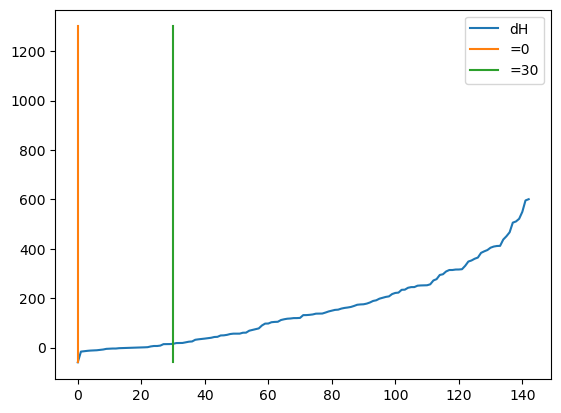

In [32]:
plt.plot(np.sort(to_plot_ten),label='dH')
plt.plot(np.zeros(4),np.linspace(-60,1300,4),label='=0')
plt.plot(np.ones(2)*30, np.linspace(-60,1300,2),label='=30')
plt.legend()

In [33]:
very_much_probable_ones = retained_ones_ten[retained_ones_ten['dH'] < 0].index

In [34]:
very_much_probable_ones

Index(['Ti4AlC3', 'Hf3PC2', 'Hf4AlC3', 'Hf3AlC2', 'Zr3AlC2', 'Ti3PC2',
       'Cr2AlC', 'Zr4AlN3', 'Ti3GaC2', 'Ti3PdC2', 'Zr3SC2', 'Ta3AlC2', 'Y3SN2',
       'Ti3CdC2', 'Sc3SN2', 'Hf4AlN3', 'Ti3GeC2', 'Nb3AlC2'],
      dtype='object')

In [35]:
retained_fifty = ['Zr4AlN3', 'Cr2AlC', 'Zr3AlC2', 'Ta3AlC2', 'Hf3AlC2', 'Hf4AlN3',
       'Zr4PC3', 'Hf4AlC3', 'Hf4PC3', 'Ti4AlC3', 'Nb3AlC2', 'Ti3PC2',
       'Ti3GaC2', 'Ti3GeC2']
same_pred = 0
for i in retained_fifty:
    if i in very_much_probable_ones:
        same_pred += 1
    else:
        print(i)

Zr4PC3
Hf4PC3


In [36]:
same_pred

12

In [37]:
len(very_much_probable_ones)

18

In [38]:
len(retained_fifty)

14

In [39]:
print(superior_to_z.shape[0],above_average.shape[0],almost_full_pos_pred.shape[0])

1608 457 143


In [40]:
most_probable_fifty = ['Y2AlC','Zr4AlN3','Fe4AlN3', 'Cr2AlC','Fe3SiC2', 'Y3AlC2','Nb2AlN', 'Y2AlN','Zr2AlC', 'Ti3SiN2',
 'Zr3AlC2', 'W2AlC','Ta3AlC2', 'Mo2AlC','Sc2AlN', 'Cr2AlN','V2AlN', 'Hf3AlC2','Hf2AlC', 'Mn2AlC','V4PC3', 'Fe4AlC3','Ru2AlC', 'Ti4PN3',
 'V4AlN3', 'Ti2PC','Ta4AlN3', 'Sc2AlC','V3AlC2', 'Mn3SiC2','Hf4AlN3', 'Fe2AlC','Sc4AlN3', 'Sc4PN3','Sc3AlC2', 'Sc3SiC2','W4AlN3', 'Os2AlC','Cr3AlC2',
 'Cr3SiC2','Mn3AlC2','Mn4AlC3','Zr4AlC3','Ti4SiN3','V4PN3','Cr4AlN3','Zr4PC3','Mo4AlC3','Nb4PC3','Hf4AlC3','Hf4PC3','Hf3SiC2','Sc4PC3',
 'Sc4AlC3','Ti4AlC3','Ti4PC3', 'Cr4AlC3', 'W4AlC3', 'Ta4PC3', 'Fe2AlN','Mn2AlN', 'Y3SiC2', 'Nb3AlC2', 'Zr3SiC2',
 'Mo3AlC2', 'Ta3SiC2', 'Ta2AlN', 'Hf2AlN', 'Zr2AlN', 'Ti3AlN2', 'Ti3PC2', 'Mn4AlN3', 'Y4AlN3', 'Fe3AlC2', 'Ti3CuC2',
 'Ti3GaC2','Ti3GeC2','V3SiC2','Nb4AlN3','Mo4AlN3', 'Re2AlC']

In [41]:
print(len(most_probable_fifty),len(most_probable_ten_pred))

81 143


In [42]:
same_pred_longer = 0
for i in most_probable_fifty:
    if i in most_probable_ten_pred:
        same_pred_longer += 1
    else:
        print(i)

V4PC3
Ti4PN3
Ti2PC
Sc4AlN3
Sc4PN3
Ti4SiN3
V4PN3
Zr4PC3
Nb4PC3
Hf4PC3
Sc4PC3
Ti4PC3
Ta4PC3
Fe2AlN


In [43]:
print(same_pred_longer)

67
